![wiki](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a8/Continuous_wavelet_transform.svg/1920px-Continuous_wavelet_transform.svg.png)

# Wavelet transform on GPU
A popular way to classify 1D signals is to transform the 1D signal into one of several types of spectrograms and then convert this spectrogram to an image. The image is then fed to a pretrained CNN which is fine-tuned during training. Transformation to the frequency domain is quite compute intensive, so we would really like to perform this function on the GPU. Tensorflow currently has no continous wavelet transform (CWT), so we have to make our own. Thankfully, this is a quite simple task using Keras custom layer.   

The benefits of doing the CWT on the GPU are:
  * Much faster than CPU (leave the CPU for data loading)
  * Avoid quantization to 8-bit integer between float inputs and float ouputs to CNN
  * The wavelets can be trained(!)
  
In this notebook we will create a custom Keras layer called Wavelet1D, ready for use in Keras models.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import glob

## Load sample GW signal
Start by loading in a sample gravitational wave signal that has a strong target signal (chirp).

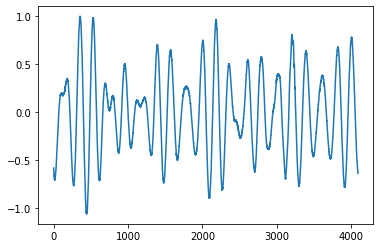

In [2]:
d_raw = np.load('../input/g2net-gravitational-wave-detection/test/0/0/2/0021f9dd71.npy')
d = d_raw[0,:]/np.max(d_raw[0,:])
plt.plot(d);

# Continous wavelet transform
The wavelet transform is computed by convolving multiple wavelets with the input signal. There are many types of wavelets, here we use the Morlet wavelet. Those who work with signal processing know that a convolution in the time domain is equivalent to a multiplication in the frequency domain. The CWT implementation here is based on [Alexander Neergaard Olesen's Python code](https://github.com/neergaard/CWT). The CWT is explored and compared with FFT in [this notebook](https://www.kaggle.com/mistag/extracting-bird-song-signatures-with-wavelets).  

The CWT is computed with the following steps:  
  * Take FFT of input signal
  * Multiply FFT spectrum with wavelet filterbank (Kronecker product)
  * Perform inverse FFT of the product
  
FFT+Kronecker+IFFT might not be the fastest implementation though, since it always computes with maximum resolution. A 2D convolution implementation can benefit from the stride parameter to reduce computations.
  
The code has been modified with additional parameters for lower and upper frequency of intereset. Rather than doing bandpass filtering of the input signal to remove unwanted frequencies, we simply calculate the wavelet scales of interest only. This can save a significant amount of processing.   

The custom Keras layers code is saved to file here, for easy use in other notebooks. We also define a custom layer for scaling logarithmic data to image data range called Scaler1D, and a layer to stack 3 channels into a RGB image.

In [3]:
%%writefile tf_cwt.py
# Based on Alexander Neergaard Olesen's CWT Python implementation. https://github.com/neergaard/CWT
# Adapted to Keras by Geir Drange
# MIT License

import tensorflow as tf
from tensorflow import keras
import tensorflow.experimental.numpy as tnp
import numpy as np
import math

# calculate CWT of input signal
class Wavelet1D(keras.layers.Layer):
    def __init__(self, nv=12, sr=1., flow=0., fhigh=0.5, batch_size=None, trainable=False):
        super(Wavelet1D, self).__init__()
        assert fhigh > flow, 'fhigh parameters must be > flow!'
        assert batch_size != None, 'batch size must be set!'
        
        self.batch_size = batch_size 
        self.nv = nv # number of voices
        self.sr = sr # sample rate (Hz)
        self.flow = flow # lowest frequency of interest (Hz)
        self.fhigh = fhigh # highest frequency of interest (Hz)
        self.trainable = trainable # True to train the wavelet filter bank

    def build(self, input_shape):
        assert len(input_shape) == 2, 'Input dimension must be 2! Dimension is {}'.format(len(input_shape))
        
        max_scale = input_shape[-1] // (np.sqrt(2) * 2)
        if max_scale <= 1:
            max_scale = input_shape[-1] // 2
        max_scale = np.floor(self.nv * np.log2(max_scale))
        scales = 2 * (2**(1/self.nv)) ** np.arange(0, max_scale + 1)
        frequencies = self.sr * (6 / (2 * np.pi)) / scales
        frequencies = frequencies[frequencies >= self.flow] # remove low frequencies
        scales = scales[0:len(frequencies)]
        frequencies = frequencies[frequencies <= self.fhigh] # remove high frequencies
        scales = scales[len(scales)-len(frequencies):len(scales)]
        # wavft
        padvalue = input_shape[-1] // 2
        n = padvalue*2+input_shape[-1]
        omega = np.arange(1, math.floor(n / 2) + 1, dtype=np.float64)
        omega = omega*(2 * np.pi) / n
        omega = np.concatenate((np.array([0]), omega, -omega[np.arange(math.floor((n - 1) / 2), 0, -1, dtype=int) - 1]))
        _wft = np.zeros([scales.size, omega.size])
        for jj, scale in enumerate(scales):
            expnt = -(scale * omega - 6) ** 2 / 2 * (omega > 0)
            _wft[jj, ] = 2 * np.exp(expnt) * (omega > 0)
        # parameters we want to use during call():
        self.wft = tf.Variable(_wft, trainable=self.trainable) # yes, the wavelets can be trainable if desired
        self.padvalue = padvalue
        self.num_scales = scales.shape[-1]
    
    # uses a loop - better to vectorize (TODO)
    def call(self, inputs):
        max_loop = tf.shape(inputs)[0]
        
        def sum_cwt(i, pre_data):
            next_data = tf.nn.embedding_lookup(inputs, i) 
            x = tf.concat([tf.reverse(next_data[0:self.padvalue], axis=[0]), next_data, tf.reverse(next_data[-self.padvalue:], axis=[0])], 0)
            f = tf.signal.fft(tf.cast(x, tf.complex64))
            cwtcfs = tf.signal.ifft(tnp.kron(tf.ones([self.num_scales, 1], dtype=tf.complex64), f) * tf.cast(self.wft, tf.complex64))
            logcwt = tf.math.log(tf.math.abs(cwtcfs[:, self.padvalue:self.padvalue + next_data.shape[-1]]))
            pre_data = tf.tensor_scatter_nd_add(pre_data, indices=[[i]], updates=[logcwt])
            i_next = i + 1
            return i_next, pre_data
                                 
        _, cwt = tf.while_loop(cond = lambda i, result: tf.less(i, max_loop),
                              body = sum_cwt,
                              loop_vars = (tf.constant(0, dtype=tf.int32), tf.zeros([self.batch_size, self.num_scales, inputs.shape[-1]], dtype = tf.float32)))
        return cwt
    
# scale input to range 0.0 - upper
class Scaler(keras.layers.Layer):
    def __init__(self, upper=1.0):
        super(Scaler, self).__init__()
        self.upper = tf.cast(upper, dtype=tf.float32) # upper value (typically 1.0 or 255.0 for image CNNs)
    
    def call(self, inputs):
        min_val = tf.math.reduce_min(inputs)
        max_val = tf.math.reduce_max(tf.math.subtract(inputs, min_val))
        return tf.math.multiply(tf.math.subtract(inputs, min_val), self.upper/max_val)
    
# Stack three channels into RGB image
class RGBStack(keras.layers.Layer):
    def __init__(self):
        super(RGBStack, self).__init__()
        
    def call(self, inputs):
        return tf.stack(inputs, axis = 3)

Writing tf_cwt.py


Import the cusomt layers:

In [4]:
from tf_cwt import Wavelet1D, Scaler, RGBStack

# CWT parameters
The CWT layer has several parameters that are to be considered hyperparameters:  
  * Number of voices per octave (nv): Scales per octave
  * Low frequency (flow): Lowest frequency of interest (Hz)
  * High frequency (fhigh): Highest frequency of interest (Hz)
  
Below we explore how these parameters affect the scaleogram (spectrogram).

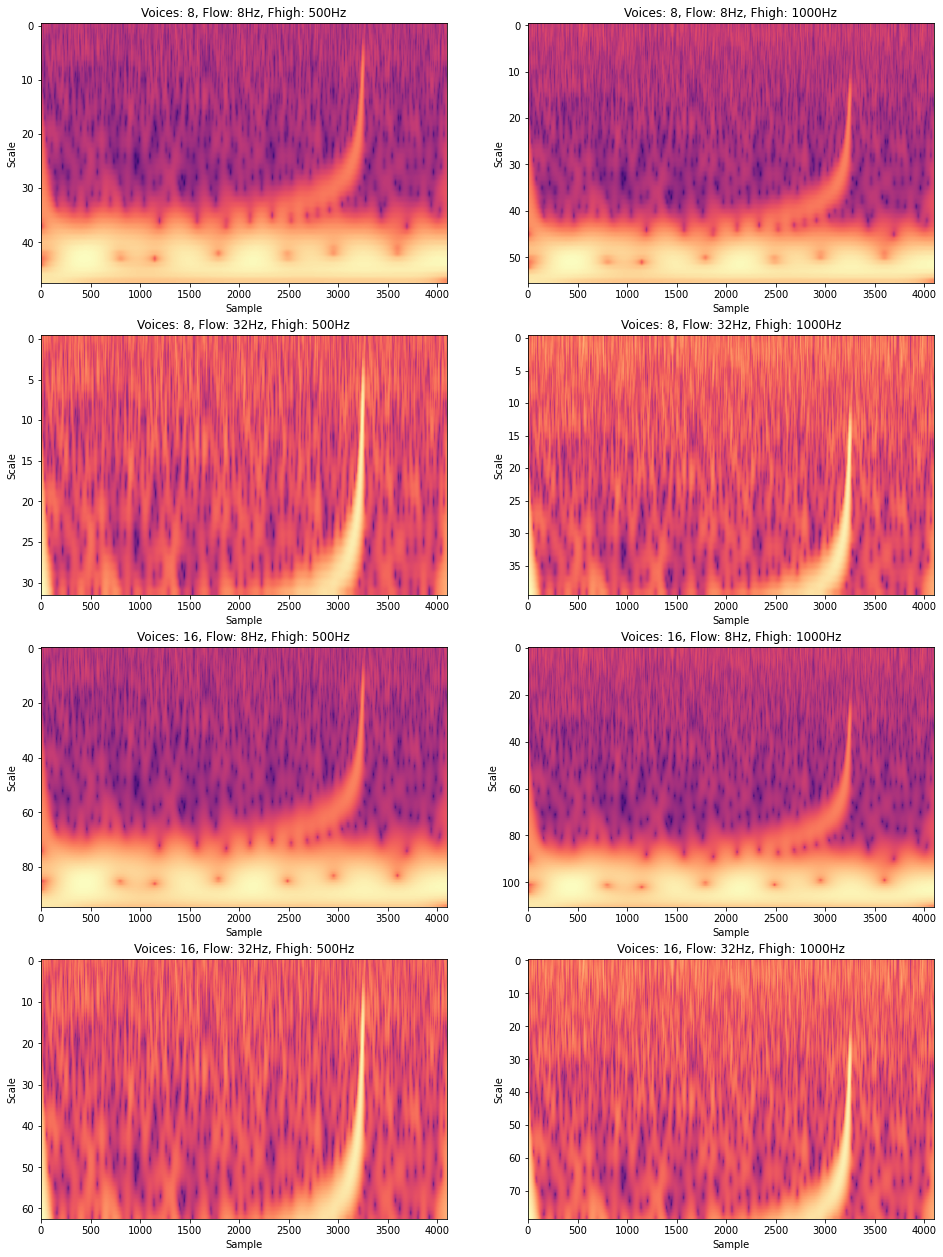

In [5]:
fig = plt.figure(figsize=(16,22))
idx = 0
for nv in [8,16]:
    for flow in [8,32]:
        for fhigh in [500, 1000]:
            y = Wavelet1D(nv=nv, sr=2048., flow=flow, fhigh=fhigh, batch_size=1)(tf.expand_dims(d, axis=0))
            y = Scaler(upper=1)(y)
            ax = plt.subplot(4, 2, 1+idx)
            plt.xlabel('Sample')
            plt.ylabel('Scale')
            plt.title('Voices: {}, Flow: {}Hz, Fhigh: {}Hz'.format(nv, flow, fhigh))
            plt.imshow(np.squeeze(y.numpy()), cmap='magma', aspect='auto') 
            idx += 1

We clearly see that a lot of low frequency noise can be omitted from the scaleogram by setting the flow parameter.

# Downsampling
The scaleogram has the same width as the input signal. This needs to be reduced to our target image size (here we choose 224). Rather than doing an image resize type operation, we can use several types of layers:  
  * Max pooling
  * Average pooling
  * 2D convolution (this can also be trained!)
  
The trick is to set the pool/filter size to (1,n), where n is the reduction factor, and stride to the same size. Let's try it out:

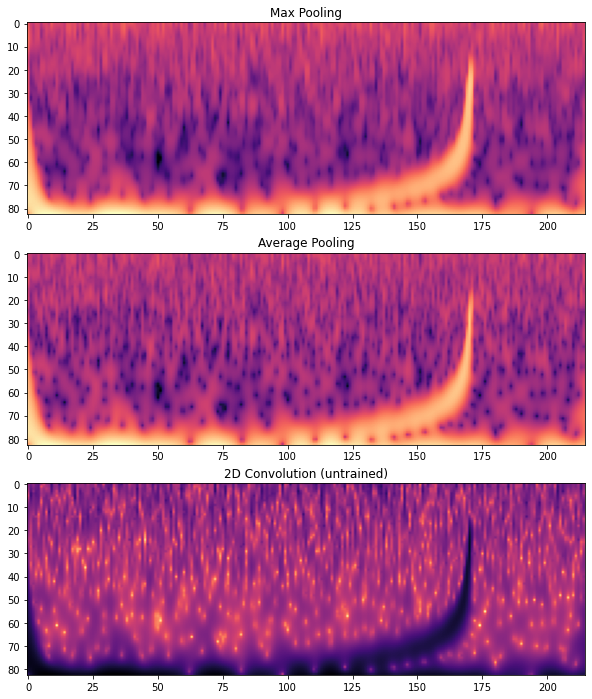

In [6]:
TARGET_IMG_SIZE = 224
STRIDE = int(np.ceil(4096/TARGET_IMG_SIZE))

y1 = Wavelet1D(nv=16, sr=2048., flow=20, fhigh=750, batch_size=1)(tf.expand_dims(d, axis=0))
y1 = Scaler(upper=1)(y1)
y1 = tf.reshape(y1, [y1.shape[0],y1.shape[1],y1.shape[2],1])
fig = plt.figure(figsize=(10,12))
ax = plt.subplot(3, 1, 1)
y2a = MaxPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(y1)
y2a = Scaler(upper=1)(y2a)
plt.title('Max Pooling')
plt.imshow(tf.reshape(y2a, [y2a.shape[1],y2a.shape[2]]).numpy(), cmap='magma', aspect='auto')
ax = plt.subplot(3, 1, 2)
y2b = AvgPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(y1)
y2b = Scaler(upper=1)(y2b)
plt.title('Average Pooling')
plt.imshow(tf.reshape(y2b, [y2b.shape[1],y2b.shape[2]]).numpy(), cmap='magma', aspect='auto') 
ax = plt.subplot(3, 1, 3)
y2c = Conv2D(filters=1, kernel_size=(1,STRIDE), strides=(1,STRIDE))(y1)
y2c = Scaler(upper=1)(y2c)
plt.title('2D Convolution (untrained)')
plt.imshow(tf.reshape(y2c, [y2c.shape[1],y2c.shape[2]]).numpy(), cmap='magma', aspect='auto');

Even if the Conv2D layer is initialized with random weights, the untrained layer performs rather well.

## Normalization of input data
There is actually no need to normalize the input data to the Wavelet1D layer, as the Scaler1D layer will do the normalization after it. The float64 format has plenty of dynamic range even for GW signals. If the CWT wavelet weights are to be trained, scaling the input first might be a good idea though. 

# Color images
So far we only use data from a single detector, but we can combine the 3 detectors into a RGB image.

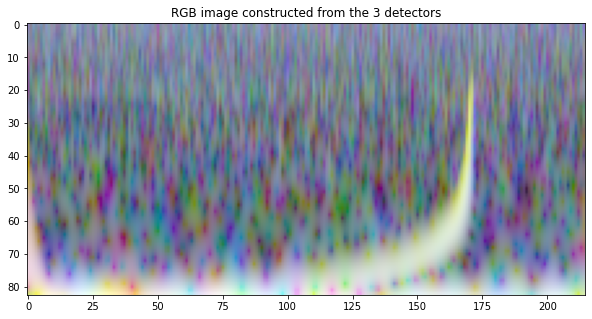

In [7]:
r = Wavelet1D(nv=16, sr=2048., flow=20, fhigh=750, batch_size=1)(tf.expand_dims(d_raw[0,:], axis=0))
r = AvgPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(tf.reshape(r, [r.shape[0],r.shape[1],r.shape[2],1]))
r = Scaler(upper=1)(r)
r = tf.reshape(r, [r.shape[1],r.shape[2]])
g = Wavelet1D(nv=16, sr=2048., flow=20, fhigh=750, batch_size=1)(tf.expand_dims(d_raw[1,:], axis=0))
g = AvgPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(tf.reshape(g, [g.shape[0],g.shape[1],g.shape[2],1]))
g = Scaler(upper=1)(g)
g = tf.reshape(g, [g.shape[1],g.shape[2]])
b = Wavelet1D(nv=16, sr=2048., flow=20, fhigh=750, batch_size=1)(tf.expand_dims(d_raw[2,:], axis=0))
b = AvgPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(tf.reshape(b, [b.shape[0],b.shape[1],b.shape[2],1]))
b = Scaler(upper=1)(b)
b = tf.reshape(b, [b.shape[1],b.shape[2]])
rgb = tf.stack([r, g, b], axis = 2)
fig = plt.figure(figsize=(10,5))
plt.title('RGB image constructed from the 3 detectors')
plt.imshow(rgb.numpy(), cmap='magma', aspect='auto');

# Zero padding
The final step before feeding the scaleogram image to a CNN is to either strech or zero-pad to square format. Again, testing is required to find the best approach. Stretching does not give more detail, but more weights in the CNN are activated.

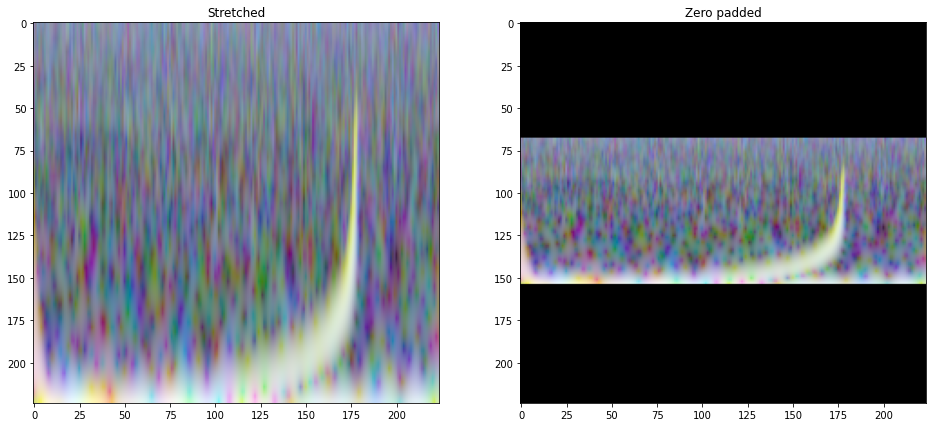

In [8]:
fig = plt.figure(figsize=(16,7))
ax = plt.subplot(1, 2, 1)
rgb3 = tf.image.resize(rgb, [224,224])
plt.title('Stretched')
plt.imshow(rgb3.numpy(), cmap='magma', aspect='auto')
ax = plt.subplot(1, 2, 2)
rgb4 = tf.image.resize_with_pad(rgb, 224, 224)
plt.title('Zero padded')
plt.imshow(rgb4.numpy(), cmap='magma', aspect='auto');

# Convert batches
Next, we can make a model that converts a batch of numpy files to CWT images. The output from this model can be used as input for a CNN classifier model.

## Dataset
First, we create a tf.dataset from numpy files. TF dataset has no direct support for reading numpy files, but the numpy format is very simple, and since all the files are of identical size, we can just skip the 128 byte numpy header and read raw data. We also normalize the data using the mean and stddev calculated in [this notebook](https://www.kaggle.com/mistag/mean-and-std-calculations-for-the-entire-dataset).

In [9]:
test_files = glob.glob('../input/g2net-gravitational-wave-detection/test/*/*/*/*.npy')

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16

with open('../input/mean-and-std-calculations-for-the-entire-dataset/train_stats.json') as fs:
    stats = json.load(fs)
mean = np.zeros((3,1), dtype=np.float64)
std = mean
for i in range(3):
    mean[i] = stats['detector'][i]['mean']
    std[i] = stats['detector'][i]['std']

def _parse_function1(filename):
    np_data = tf.io.read_file(filename)
    np_data = tf.strings.substr(np_data, 128, 98304) # header is 128 bytes (skip)
    np_data = tf.reshape(tf.io.decode_raw(np_data, tf.float64), (3, 4096))
    np_data = tf.math.divide(tf.math.subtract(np_data, mean), std) # standardize
    return tf.cast(np_data, tf.float32)

test_ds = tf.data.Dataset.from_tensor_slices(test_files)
test_ds = test_ds.map(_parse_function1, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

## CWT to image model
Here we build a model that takes a batch of numpy arrays as input and converts this into CWT images.

In [10]:
TARGET_IMG_SIZE = 224 # image size expected by the CNN model
# skip start to make img_size integer multiple of 4096
OFFSET = 4096-int(np.floor(4096/224))*TARGET_IMG_SIZE
STRIDE = (4096-OFFSET)//TARGET_IMG_SIZE

# CTW model
def build_cwt_model(nv=16, flow=20, fhigh=700, batch_size=BATCH_SIZE):
    inputs = Input(shape=(3, 4096))
    # channels
    r = Wavelet1D(nv=nv, sr=2048., flow=flow, fhigh=fhigh, batch_size=batch_size)(inputs[:,0,OFFSET:])  
    g = Wavelet1D(nv=nv, sr=2048., flow=flow, fhigh=fhigh, batch_size=batch_size)(inputs[:,1,OFFSET:]) 
    b = Wavelet1D(nv=nv, sr=2048., flow=flow, fhigh=fhigh, batch_size=batch_size)(inputs[:,2, OFFSET:]) 
    # combine into rgb
    rgb = RGBStack()([r, g, b])
    # downsample
    rgb = AvgPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(rgb) 
    rgb = Scaler(upper=255.)(rgb) # adjust 'upper' according to CNN 
    
    return tf.keras.Model(inputs, rgb, name="Wavlet")
    
cwt_model = build_cwt_model()
cwt_model.summary()

Model: "Wavlet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 4096)]    0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 4032)         0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 4032)         0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 4032)         0           input_1[0][0]                    
_____________________________________________________________________________________________

The simply convert a batch by calling .predict:

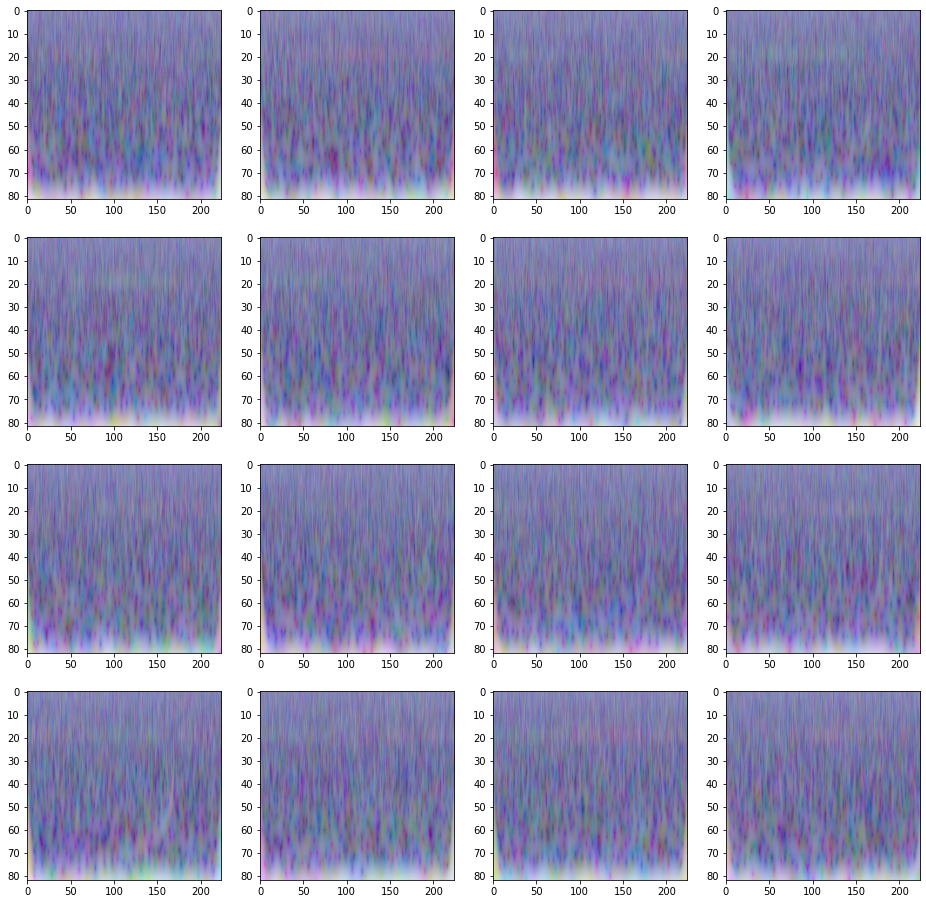

In [11]:
cwt_model.compile()
pred = cwt_model.predict(test_ds.take(1))

fig = plt.figure(figsize=(16,16))
for i in range(BATCH_SIZE):
    ax = plt.subplot(4, 4, 1+i)
    plt.imshow(pred[i,:,:]/255, aspect='auto') 

That's it! Coming up: Training a model with these layers.